In [1]:
import torch
device = "mps"
def generate_grid_edges(n, m):
    edges = []
    for i in range(n):
        for j in range(m):
            current = i * m + j
            if i > 0: edges.append((current, (i - 1) * m + j, "north"))
            if i < n - 1: edges.append((current, (i + 1) * m + j, "south"))
            if j < m - 1: edges.append( (current, i * m + (j + 1), "east"))
            if j > 0: edges.append((current, i * m + (j - 1), "west"))# West edge

    return {"edges": edges}

In [2]:
#from core.spatial.energy_graph import PointEnergyMLP
from core.spatial.diffusion import samples, ScheduleLogLinear, training_loop


constraints = {
    "north": [2, 2],
    "south": [2, 2],
    "east":  [2, 2],
    "west":  [2, 2],
    "northeast": [2, 2],
    "northwest": [2, 2],
    "southeast": [2, 2],
    "southwest": [2, 2]
    }

state_path = "outputs/checkpoints/direction_state.pth"

#model = PointEnergyMLP(constraints, dim = 2)
#model.load_state_dict(torch.load(state_path, map_location = device))


schedule = ScheduleLogLinear(N=200, sigma_min=0.005, sigma_max=10)
#trainer  = training_loop(loader, model, schedule, epochs=000)
#losses   = [ns.loss.item() for ns in trainer]

n, m = (2, 2)
cond = generate_grid_edges(n, m)
batchsize = n * m

xt = torch.randn([1,batchsize,2]) 
#*xt, x0  = samples(model, schedule.sample_sigmas(20), gam=2, cond = cond, batchsize = batchsize, xt = xt)

#print("Solution:")
#print(x0[0].cpu().detach().numpy())



In [3]:
#from domains.spatial.direction_domain import direction_executor
#direction_executor.visualize(x0[0].cpu(), "outputs/dir_cons")
import matplotlib.pyplot as plt

In [4]:
import torch
import csv
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms as tf

## Dataset utility functions

# Mainly used to discard labels and only output data
class MappedDataset(Dataset):
    def __init__(self, dataset, fn):
        self.dataset = dataset
        self.fn = fn
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, i):
        return self.fn(self.dataset[i])

img_train_transform = tf.Compose([
    tf.RandomHorizontalFlip(),
    tf.ToTensor(),
    tf.Lambda(lambda t: (t * 2) - 1)
])

img_normalize = lambda x: ((x + 1)/2).clamp(0, 1)


## Toy datasets

class Swissroll(Dataset):
    def __init__(self, tmin, tmax, N, center=(0,0), scale=1.0):
        t = tmin + torch.linspace(0, 1, N) * tmax
        center = torch.tensor(center).unsqueeze(0)
        self.vals = center + scale * torch.stack([t*torch.cos(t)/tmax, t*torch.sin(t)/tmax]).T

    def __len__(self):
        return len(self.vals)

    def __getitem__(self, i):
        return self.vals[i]

class DatasaurusDozen(Dataset):
    def __init__(self, csv_file, dataset, enlarge_factor=15, delimiter='\t', scale=50, offset=50):
        self.enlarge_factor = enlarge_factor
        self.points = []
        with open(csv_file, newline='') as f:
            for name, *rest in csv.reader(f, delimiter=delimiter):
                if name == dataset:
                    point = torch.tensor(list(map(float, rest)))
                    self.points.append((point - offset) / scale)

    def __len__(self):
        return len(self.points) * self.enlarge_factor

    def __getitem__(self, i):
        return self.points[i % len(self.points)]

def interpolate_polyline(points, num_samples):
    """
    Given a list of 2D points defining a polyline,
    sample num_samples points uniformly along its arc length.
    """
    points = np.array(points)
    # Compute distances between consecutive points
    dists = np.linalg.norm(np.diff(points, axis=0), axis=1)
    cumdist = np.concatenate(([0], np.cumsum(dists)))
    total_length = cumdist[-1]
    # Equally spaced arc-length values
    sample_dists = np.linspace(0, total_length, num_samples)
    samples = []
    for d in sample_dists:
        # Find which segment d falls in
        seg = np.searchsorted(cumdist, d, side='right') - 1
        seg = min(seg, len(dists) - 1)
        # Compute local interpolation parameter
        t = (d - cumdist[seg]) / dists[seg] if dists[seg] > 0 else 0
        sample = (1 - t) * points[seg] + t * points[seg + 1]
        samples.append(sample)
    return np.array(samples)

class TreeDataset(Dataset):
    def __init__(self, branching_factor=4, depth=3, num_samples_per_path=30):
        """
        Initializes a tree dataset where each leaf of the tree lies on the
        circle of radius 1. The tree is constructed with the given branching_factor
        and depth. Each leaf’s path is sampled uniformly, and each sampled point
        is given the label of the leaf.

        Parameters:
         - branching_factor (int): number of branches at each node.
         - depth (int): number of branchings (excluding the root).
                        Total leaves = branching_factor ** depth.
         - num_samples_per_path (int): number of points sampled along each path.
        """
        self.data = []
        self.total_leaves = branching_factor ** depth

        # Iterate over each leaf index
        for i in range(self.total_leaves):
            # Build the sequence of nodes along the path from the root to this leaf.
            # Start with the root at (0, 0)
            path_points = [np.array([0.0, 0.0])]

            # For each level l (1 to depth), compute the branch node.
            for l in range(1, depth + 1):
                # Group size for this level (leaves per branch node)
                group_size = branching_factor ** (depth - l)  # For l == depth, group_size == 1.
                # A_l is the branch index for level l
                A_l = i // group_size
                # Compute the average index for all leaves under this branch node
                avg_index = A_l * group_size + (group_size - 1) / 2.0
                # Compute angular coordinate (all leaves are uniformly spaced on the circle)
                theta = avg_index * (2 * np.pi / self.total_leaves)
                # Set radius proportional to the level (leaf at level==depth has r==1)
                r = l / depth
                p = np.array([r * np.cos(theta), r * np.sin(theta)])
                path_points.append(p)

            # Sample points uniformly along the polyline defined by the path
            samples = interpolate_polyline(path_points, num_samples_per_path)
            # Append each sample with its label (the leaf index)
            for sample in samples:
                # Each item is a tuple: (2D coordinate tensor, label)
                self.data.append((torch.tensor(sample, dtype=torch.float32), i))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

SwissLearner

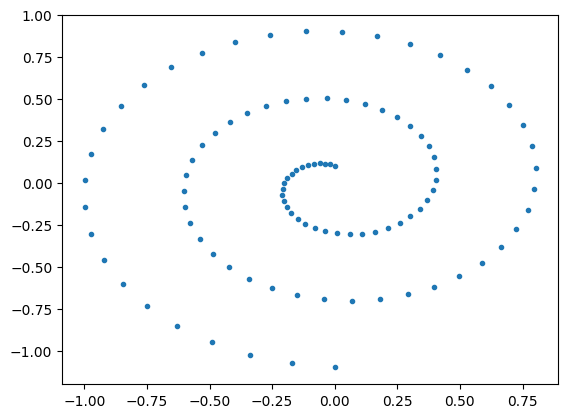

In [5]:
from core.spatial.energy_graph import  TimeInputMLP
from core.spatial.diffusion import samples, ScheduleLogLinear, training_loop, ScheduleDDPM
#from datasets.ccsp_dataset import Swissroll
from torch.utils.data import DataLoader
import numpy as np

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def plot_batch(batch):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker='.')

dataset = Swissroll(np.pi/2, 5*np.pi, 100)
loader = DataLoader(dataset, batch_size=2130)

plot_batch(next(iter(loader)))


100%|██████████| 50000/50000 [04:32<00:00, 183.69it/s]


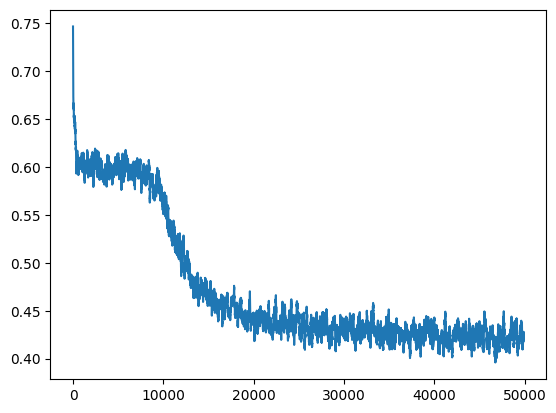

In [6]:
model = TimeInputMLP(hidden_dims=(16,128,128,128,128,16))
trainer = training_loop(loader, model, schedule, epochs=50000, lr=1e-3)
losses = [ns.loss.item() for ns in trainer]

plt.plot(moving_average(losses, 100))


In [8]:


batchsize = 1500
xt = torch.randn([batchsize,2]).to("mps") * schedule.sample_sigmas(20)[0]


*xt, x0  = samples(model, schedule.sample_sigmas(20), gam=2, cond = cond, batchsize = batchsize, xt = xt)

plot_batch(x0)

IndexError: too many indices for tensor of dimension 2